## Preferential Sampling Algorithm

### Table of contents :
1. [Introduction](#1.-Introduction)
2. [Data preparation](#2.-Data-Preparation)
3. [Fairness Before Debiasing](#3.-Fairness-Before-Debiasing)
    * 3.1 [Bias In The Data](#3.1-Bias-In-The-Data)
    * 3.2 [Bias In The Model](#3.2-Bias-In-The-Model)
4. [Preferential Sampling Algorithm](#4.-Preferential-Sampling-Algorithm)
5. [Fairness After Debiasing](#5.-Fairness-After-Debiasing)
    * 5.1 [Bias In The Data](#5.1-Bias-In-The-Data)
    * 5.2 [Bias In The Model](#5.2-Bias-In-The-Model)
6. [Fairness Comparission (Orignial vs Mitigated)](#6.-Fairness-Comparission-(Orignial-vs-Mitigated)) 
    * 6.1 [Data Fairness](#6.1-Data-Fairness)
    * 6.2 [Model Fairness](#6.2-Model-Performance-and-Fairness)
7. [Summary](#7.-Summary)
8. [References](#8.-References)

### 1. Introduction

Welcome!

The goal of this tutorial is to showcase the usage of the Preferential Sampling (PS) algorithm to enhance fairness metrics across various datasets. Preferential Sampling is a pre-processing technique that reduces the discrimination in the dataset by using a sampling technique. In the previous tutorials we have discussed other pre-processing algorithms such as "Reweighing[link]" and "Massage Data[link]". In this tutorial, we will cover the key concepts of the algorithm and provide step-by-step instructions to implement it on various datasets.

Before we go into detailed explanation, here is a sneak peek into the steps involved in the process.

In [1]:
# Preparation
!git clone https://github.com/sony/nnabla-examples.git
%cd nnabla-examples/responsible_ai
import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread('images/preferential_sampling_workflow_diagram.png')
cv2_imshow(img)

In [3]:
import numpy as np
import sys
from collections import defaultdict
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,confusion_matrix,roc_curve, auc

sys.path.append('../responsible_ai/')
from preferential_sampling.utils import *
from utils.data_loader import *

### 2. Data Preparation

First, let's load the dataset and split it into training and testing sets.

In [4]:
data_loader = load_data(data_name='compas', download = True)
X_train, X_test, Y_train, Y_test, Z_train, Z_test = data_loader.train_test_split(test_size=0.3,shuffle=True,random_state=0)

To prepare the data for fairness evaluation, we need to define the target attribute, sensitive attribute and privileged/unprivileged classes.

In [5]:
target_attribute = data_loader.target_variable[0]
positive_class = data_loader.favorable_label
negative_class= data_loader.unfavorable_label
sensitive_attribute = data_loader.protected_attribute[0]
privileged_class= data_loader.privileged_classes[0]
unprivileged_class = data_loader.unprivileged_classes[0]

In [6]:
print(f"target_attribute : {target_attribute}")
print(f"positive_class : {positive_class}")
print(f"negative_class : {negative_class}")
print(f"sensitive_attribute : {sensitive_attribute}")
print(f"privileged_class : {privileged_class}")
print(f"unprivileged_class : {unprivileged_class}")

target_attribute : two_year_recid
positive_class : 1
negative_class : 0
sensitive_attribute : sex
privileged_class : 1
unprivileged_class : 0


### 3. Fairness Before Debiasing

#### 3.1 Bias In The Data

Now let us check the data bias in the dataset using "Statistical Parity Difference[link]" and "Disparate Impact[link]" metrics before model training. 

In [7]:
dpd_before_debiasing = statistical_parity_difference(X_train,Y_train,target_attribute,positive_class,sensitive_attribute,privileged_class,unprivileged_class)
di_before_debiasing = disparate_impact(X_train,Y_train,target_attribute,positive_class,sensitive_attribute,privileged_class,unprivileged_class)

In [8]:
print(f"Before Data debiasing : DPD {abs(dpd_before_debiasing)} Disparate Impact : {abs(di_before_debiasing)}" )

Before Data debiasing : DPD 0.12185074184660516 Disparate Impact : 0.8122901942928004


#### 3.2 Bias In The Model

Here in this tutorial we shall train multiple classifiers to evaluate their performance and fairness before and after debiasing the dataset with the Preferential Sampling Algorithm. To keep it simple and facilitate understanding, we have included only the Logistic Regression, GradientBoostingClassifier, Random Forest Classifier, and XGB Classifier in the models list. However, you can add your preferred models to the list and run other experiments accordingly.

In [9]:
models = []
models.append(('LR', LogisticRegression(max_iter=500,random_state=42)))
models.append(('GBC', GradientBoostingClassifier(random_state=42)))
models.append(('RF', RandomForestClassifier(random_state=42)))
models.append(('XGB', xgb.XGBClassifier(eval_metric='mlogloss',use_label_encoder=False)))

In [10]:
scale_orig = StandardScaler() # scale before modelling
S_train = scale_orig.fit_transform(X_train)
S_test = scale_orig.fit_transform(X_test)

#### Evaluation

In [11]:
models_names, dpd_list, di_list, eod_list, aaod_list, accuracy_list, roc_auc_list, preds_prob = [], [], [], [], [], [], [], []
for name, model in models:
    clf = train_model(model, S_train, Y_train.values.ravel())
    y_score = clf.predict_proba(S_test)[:, 1]
    preds = (y_score > 0.5).astype(int)
    accuracy = accuracy_score(Y_test, preds)
    fpr, tpr, _ = roc_curve(Y_test, preds)
    roc_auc = auc(fpr, tpr)
    
    DPD, DI, EOD,AAOD = get_model_fairness(Y_test,Z_test[sensitive_attribute]==privileged_class,preds)
    dpd_list.append(abs(DPD))
    di_list.append(abs(DI))
    eod_list.append(abs(EOD))
    aaod_list.append(abs(AAOD))
    accuracy_list.append(accuracy)
    preds_prob.append(y_score)
    roc_auc_list.append(roc_auc)
    models_names.append(name)
    print(f"Model : {name} accuracy : {round(accuracy,2)} DPD : {abs(round(DPD,3))} ,DI : {abs(round(DI,3))}, EOD : {abs(round(EOD,3))} , AAOD : {abs(round(AAOD,3))}")

Model : LR accuracy : 0.65 DPD : 0.19 ,DI : 0.76, EOD : 0.108 , AAOD : 0.167
Model : GBC accuracy : 0.68 DPD : 0.176 ,DI : 0.763, EOD : 0.091 , AAOD : 0.141
Model : RF accuracy : 0.65 DPD : 0.132 ,DI : 0.801, EOD : 0.071 , AAOD : 0.1
Model : XGB accuracy : 0.67 DPD : 0.185 ,DI : 0.757, EOD : 0.107 , AAOD : 0.151


Check if the fairness metric indicates any bias towards a particular group. If such bias exists, use the Preferential Sampling algorithm to address it and make the model more fair.

In [12]:
before_debiasing = defaultdict(dict)
before_debiasing["Accuracy"] = accuracy_list
before_debiasing["DPD"] = dpd_list
before_debiasing["DI"] = di_list
before_debiasing["EOD"] = eod_list
before_debiasing["AAOD"] = aaod_list
before_debiasing["AUC"] = roc_auc_list

### 4. Preferential Sampling Algorithm

Preferential Sampling (PS) is a method used to create a discrimination-free training set by using a sampling technique. 

The idea behind PS is that data objects that are close to the borderline where discrimination may have occurred, are more likely to have been treated unfairly or favored due to discrimination in the dataset. Therefore, PS gives preference to these borderline objects when selecting samples.

To implement PS, the training dataset is divided into four groups based on the sensitive attribute (SA) and class labels (c). 

These groups are DP (Discriminated community with Positive class labels), DN (Discriminated community with Negative class labels), PP (Privileged community with Positive class labels), and PN (Privileged community with Negative class labels).

$$\begin{align*}
DP & := \{x \in D \mid x.\text{SA} = s \land x.c = +\} \\
DN & := \{x \in D \mid x.\text{SA} = s \land x.c = -\} \\
PP & := \{x \in D \mid x.\text{SA} = \bar{s} \land x.c = +\} \\
PN & := \{x \in D \mid x.\text{SA} = \bar{s} \land x.c = -\} \\
\end{align*}$$
$$ Where as 
 D: Labeled Dataset, SA: Sensitive Attribute, c: Class label, x: Features In Dataset D$$

To identify the borderline objects, PS first trains a ranker on the training data. This ranker is used to sort the objects in the DP and PP groups in ascending order, and the objects in the DN and PN groups in descending order, based on their positive class probabilities. This sorting ensures that objects with higher ranks are closer to the borderline.

To make the dataset bias-free, PS calculates the expected size for each group using the formula: 

$$v \in SA \text{ and } c \in C \text{ by } \frac{|v| \times |c|}{|D|}$$

The PS process starts with the original training dataset and iteratively adjusts it. 

For the DP and PN groups, samples are duplicated, while for the DN and PP groups, samples are removed. The size of a group is reduced by removing the data objects that are closest to the borderline (i.e., the top element). On the other hand, to increase the sample size, the data object that is closest to the borderline is duplicated.



Beflow figure is an illustration of "Preferential Sampling (PS)", for 40 data points. Data points of the desired class and the negative class are represented by + and - symbols respectively. 

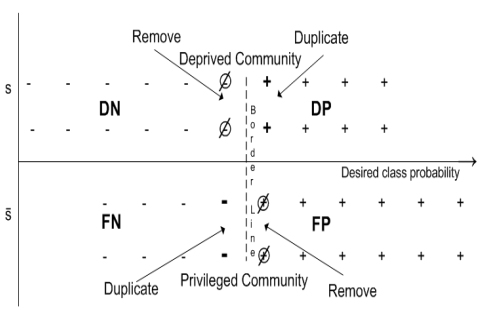

In [13]:
img = cv2.imread('images/preferential_sampling_representation.PNG')
cv2_imshow(img)

Now let's implement the Preferential Sampling algorithm

In [14]:
def preferential_sampling(df, df_c, class_attribute, favourable_class, un_favourable_class, df_s, sensitive_attribute, privileged_class, unprivileged_class):
    # Separate four groups based on sensitive attribute  and class attribute: DP, DN, PP, PN
    df = pd.concat([df, df_c], axis=1)
    DP = df[(df_s[sensitive_attribute] == unprivileged_class) & (df_c[class_attribute] == favourable_class)]
    DN = df[(df_s[sensitive_attribute] == unprivileged_class) & (df_c[class_attribute] == un_favourable_class)]
    PP = df[(df_s[sensitive_attribute] == privileged_class) & (df_c[class_attribute] == favourable_class)]
    PN = df[(df_s[sensitive_attribute] == privileged_class) & (df_c[class_attribute] == un_favourable_class)]

    # Learn a ranking model ranker on D
    ranker = RandomForestClassifier(random_state=42)
    X = df.drop([class_attribute], axis=1)
    y = df[class_attribute]
    ranker.fit(X, y)
    # Arrange the elements of DP and PP in ascending order
    # DN and PN in descending order
    DP_sorted = DP.assign(ranker_score=ranker.predict_proba(DP.drop([class_attribute], axis=1))[:, 1]).sort_values(
        'ranker_score')
    PP_sorted = PP.assign(ranker_score=ranker.predict_proba(PP.drop([class_attribute], axis=1))[:, 1]).sort_values(
        'ranker_score')
    DN_sorted = DN.assign(ranker_score=ranker.predict_proba(DN.drop([class_attribute], axis=1))[:, 1]).sort_values(
        'ranker_score', ascending=False)
    PN_sorted = PN.assign(ranker_score=ranker.predict_proba(PN.drop([class_attribute], axis=1))[:, 1]).sort_values(
        'ranker_score', ascending=False)

    # Step 4: Calculate the expected size for each combination of v ∈ SenstiveAttribute and c ∈ ClassAttribute by |v| * |c| / |D|
    expected_sizes = {}
    for v in [privileged_class, unprivileged_class]:
        for c in [favourable_class, un_favourable_class]:
            expected_sizes[(v, c)] = (len(df[df[sensitive_attribute] == v]) * len(
                df[df[class_attribute] == c])) / len(df)

    DP_resampled = pd.DataFrame()
    PN_resampled = pd.DataFrame()
    DN_resampled = pd.DataFrame()
    PP_resampled = pd.DataFrame()

    for v in [privileged_class, unprivileged_class]:
        for c in [favourable_class, un_favourable_class]:
            expected_size = expected_sizes[(v, c)]
            group = df[(df[sensitive_attribute] == v) & (df_c[class_attribute] == c)]
            size_of_group = len(group)
            no_resubstitution_skipping = round(abs(expected_size - size_of_group))
            if expected_size > len(group):
                if v == unprivileged_class and c == favourable_class:
                    if no_resubstitution_skipping > len(group):
                        n_repeats = int(expected_size // size_of_group)
                        DP_resampled = pd.concat([DP_sorted]*n_repeats)
                        n_remaining = int(expected_size % size_of_group)
                        if n_remaining > 0:
                            DP_resampled = pd.concat([DP_resampled,DP_sorted.head(n_remaining)])
                    else:
                        DP_resampled = pd.concat([DP_sorted[:no_resubstitution_skipping], DP_sorted])
                if v == privileged_class and c == un_favourable_class:
                    if no_resubstitution_skipping > len(group):
                        n_repeats = int(expected_size // size_of_group)
                        PN_resampled = pd.concat([PN_sorted]*n_repeats)
                        n_remaining = int(expected_size % size_of_group)
                        if n_remaining > 0:
                            DP_resampled = pd.concat([PN_resampled,PN_sorted.head(n_remaining)])
                    PN_resampled = pd.concat([PN_sorted[:no_resubstitution_skipping], PN_sorted])
            elif expected_size < len(group):
                if v == unprivileged_class and c == un_favourable_class:
                    DN_resampled = DN_sorted[no_resubstitution_skipping:]
                if v == privileged_class and c == favourable_class:
                    PP_resampled = PP_sorted[no_resubstitution_skipping:]
            else:
                if v == privileged_class and c == favourable_class:
                    PP_resampled = group
                if v == unprivileged_class and c == un_favourable_class:
                    DN_resampled = group
                if v == privileged_class and c == un_favourable_class:
                    PN_resampled = group
                if v == unprivileged_class and c == favourable_class:
                    DP_resampled = group
    resampled_df = pd.concat([DP_resampled, PN_resampled, DN_resampled, PP_resampled])
    resampled_features = resampled_df.drop([class_attribute, 'ranker_score'], axis=1)
    resampled_protected_attr = resampled_df[sensitive_attribute].to_frame()
    resampled_class_attr = resampled_df[class_attribute].to_frame()
    return resampled_features, resampled_protected_attr, resampled_class_attr

In [15]:
resampled_features, resampled_protected_attr, resampled_class_attr = preferential_sampling(X_train, Y_train, target_attribute, positive_class, negative_class, Z_train, sensitive_attribute, privileged_class, unprivileged_class)

### 5. Fairness After Debiasing
#### 5.1 Bias In The Data

In [16]:
dpd_after_debiasing = statistical_parity_difference(resampled_features,resampled_class_attr,target_attribute,positive_class,sensitive_attribute,privileged_class,unprivileged_class)
di_after_debiasing = disparate_impact(resampled_features,resampled_class_attr,target_attribute,positive_class,sensitive_attribute,privileged_class,unprivileged_class)

In [17]:
print(f"After Data debiasing : DPD {abs(dpd_after_debiasing)} Disparate Impact : {abs(di_after_debiasing)}" )

After Data debiasing : DPD 0.0003207343208782021 Disparate Impact : 1.0005830237210631


Standardize the resampled features and assign the resampled class attribute to Y_train

In [18]:
scale_orig = StandardScaler()
S_train = scale_orig.fit_transform(resampled_features)
Y_train = resampled_class_attr

#### 5.2 Bias In The Model
Let's train the model with the relabelled target attribute.

In [19]:
models_names, dpd_list, di_list, eod_list, aaod_list, accuracy_list, roc_auc_list, preds_prob = [], [], [], [], [], [], [], []
for name, model in models:
    clf = train_model(model, S_train, Y_train.values.ravel())
    y_score = clf.predict_proba(S_test)[:, 1]
    preds = (y_score > 0.5).astype(int)
    accuracy = accuracy_score(Y_test, preds)
    fpr, tpr, _ = roc_curve(Y_test, preds)
    roc_auc = auc(fpr, tpr)
    
    DPD, DI, EOD,AAOD = get_model_fairness(Y_test,Z_test[sensitive_attribute]==privileged_class,preds)
    dpd_list.append(abs(DPD))
    di_list.append(abs(DI))
    eod_list.append(abs(EOD))
    aaod_list.append(abs(AAOD))
    accuracy_list.append(accuracy)
    preds_prob.append(y_score)
    roc_auc_list.append(roc_auc)
    models_names.append(name)
    print(f"Model : {name} accuracy : {round(accuracy,2)} DPD : {abs(round(DPD,3))} ,DI : {abs(round(DI,3))}, EOD : {abs(round(EOD,3))} , AAOD : {abs(round(AAOD,3))}")

Model : LR accuracy : 0.64 DPD : 0.059 ,DI : 1.1, EOD : 0.105 , AAOD : 0.097
Model : GBC accuracy : 0.68 DPD : 0.075 ,DI : 0.888, EOD : 0.008 , AAOD : 0.033
Model : RF accuracy : 0.64 DPD : 0.009 ,DI : 0.984, EOD : 0.086 , AAOD : 0.072
Model : XGB accuracy : 0.66 DPD : 0.014 ,DI : 1.023, EOD : 0.081 , AAOD : 0.051


In [20]:
after_debiasing = defaultdict(dict)
after_debiasing["Accuracy"] = accuracy_list
after_debiasing["DPD"] = dpd_list
after_debiasing["DI"] = di_list
after_debiasing["EOD"] = eod_list
after_debiasing["AAOD"] = aaod_list
after_debiasing["AUC"] = roc_auc_list

Now that we have all the data, let's plot and compare the bias of the original and modified datasets to determine if the fairness of the dataset and model has improved or not.

### 6. Fairness Comparission (Orignial vs Mitigated)

#### 6.1 Data Fairness

Compare the Statistical Parity Difference(Demogrpahic Parity) of Original and Resampled dataset.

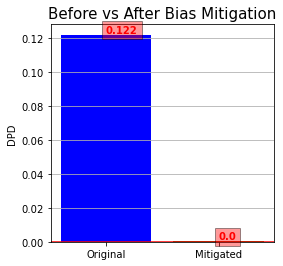

In [21]:
plot_fairness_comp(abs(dpd_before_debiasing),abs(dpd_after_debiasing))

Compare the Disparate Impact of Original and Resampled dataset.

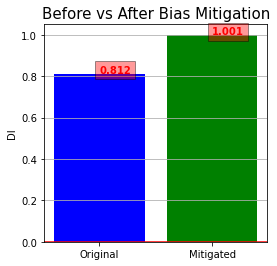

In [22]:
plot_fairness_comp(abs(di_before_debiasing),abs(di_after_debiasing),metric = "DI")

#### 6.2 Model Performance and Fairness

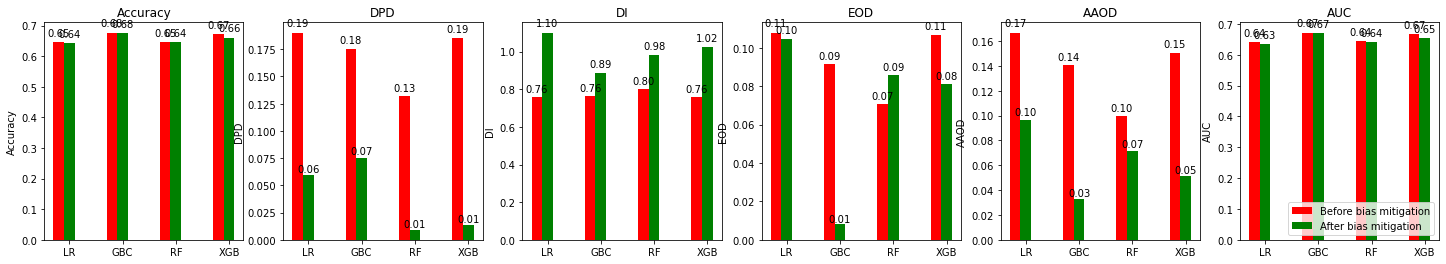

In [23]:
def autolabel(rects, axes):
        for rect in rects:
            h = rect.get_height()
            if h < 0:
                axes.text(rect.get_x() + rect.get_width() / 2., h - 0.04, '%.2f' % float(h),
                          ha='center', va='bottom')
            else:
                axes.text(rect.get_x() + rect.get_width() / 2., 1.02 * h, '%.2f' % float(h),
                          ha='center', va='bottom')
ind = np.arange(len(models_names))  # the x locations for the groups
width = 0.2  # the width of the bars

fig, axs = plt.subplots(1, 6, figsize=(25, 4))

for ax,metric in zip (axs.ravel(),after_debiasing.keys()):
    fairness_base_bar = ax.bar(ind, before_debiasing[metric], width, color='r',
                        label='Before bias mitigation')
    fairness_mitigated_bar = ax.bar(ind + width, after_debiasing[metric], width, color='g',
                                     label='After bias mitigation')
    ax.set_ylabel(metric)
    ax.set_xticks(ind + width)
    ax.set_xticklabels(models_names)
    ax.title.set_text(metric)
    autolabel(fairness_base_bar, axes=ax)
    autolabel(fairness_mitigated_bar, axes=ax)
plt.legend(loc ="lower right")
plt.show()

Above plots indicate whether there is any improvement in model fairness after application of "Massage Data Preprocessing Algorithm". We used several fairness metrics such as Demographic Parity, Disparate Impact, Equal Opportunity Difference and Equalised odds, along with Accuracy and ROC-AUC for measuring the model performance. However, in some cases, it can be observed that the model fairness decreases for some fairness metrics (Equal Opportunity Difference and Equalised odds) due to a large number of removing/duplicating the data objects. If the number of removing/duplicating the data objects are minimized, other fairness metrics could be improved.

### 7. Summary

This tutorial provides a high-level overview of the "Preferential Sampling" algorithm and its utilization for reducing bias in datasets. PS method aims to create a discrimination-free training set where each group is balanced and representative. It also helps to mitigate the effects of discrimination in the dataset and promotes fairness in machine learning models.

### 8. References

Kamiran, Faisal, and Toon Calders. "Classification with no discrimination by preferential sampling." In Proc. 19th Machine Learning Conf. Belgium and The Netherlands, vol. 1, no. 6. Citeseer, 2010.